In [9]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import base64
import time
import datetime

def get_file_content_chrome(driver, uri):
    result = driver.execute_async_script("""
      var uri = arguments[0];
      var callback = arguments[1];
      var toBase64 = function(buffer){for(var r,n=new Uint8Array(buffer),t=n.length,a=new Uint8Array(4*Math.ceil(t/3)),i=new Uint8Array(64),o=0,c=0;64>c;++c)i[c]="ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+/".charCodeAt(c);for(c=0;t-t%3>c;c+=3,o+=4)r=n[c]<<16|n[c+1]<<8|n[c+2],a[o]=i[r>>18],a[o+1]=i[r>>12&63],a[o+2]=i[r>>6&63],a[o+3]=i[63&r];return t%3===1?(r=n[t-1],a[o]=i[r>>2],a[o+1]=i[r<<4&63],a[o+2]=61,a[o+3]=61):t%3===2&&(r=(n[t-2]<<8)+n[t-1],a[o]=i[r>>10],a[o+1]=i[r>>4&63],a[o+2]=i[r<<2&63],a[o+3]=61),new TextDecoder("ascii").decode(a)};
      var xhr = new XMLHttpRequest();
      xhr.responseType = 'arraybuffer';
      xhr.onload = function(){ callback(toBase64(xhr.response)) };
      xhr.onerror = function(){ callback(xhr.status) };
      xhr.open('GET', uri);
      xhr.send();
      """, uri)
    if type(result) == int :
        raise Exception("Request failed with status %s" % result)
    return base64.b64decode(result)


today = datetime.datetime.today().strftime('%Y%m%d')

options = Options()
options.add_experimental_option('detach', True)
options.add_experimental_option('excludeSwitches', ['enable-logging'])
options.add_argument("headless")
driver = webdriver.Chrome('/path/to/chromedriver', options=options) # Replace with path to your local chromedriver executable
actions = ActionChains(driver)

url = 'https://www.cboe.com/delayed_quotes/spx/quote_table'
driver.get(url)

time.sleep(10)

option_range_button = driver.find_element(By.XPATH, "/html/body/main/section[1]/div/div/div/div/div[2]/div[2]/div[2]/div[2]/div[3]/div/div[2]/div/div/div/div[1]/div[1]")
driver.execute_script("arguments[0].scrollIntoView({block: 'center', inline: 'nearest'})", option_range_button)
actions.click(option_range_button).send_keys(Keys.UP).send_keys(Keys.ENTER).perform()

expiration_button = driver.find_element(By.XPATH, "/html/body/main/section[1]/div/div/div/div/div[2]/div[2]/div[2]/div[2]/div[4]/div/div[2]/div/div/div/div[1]")
actions.click(expiration_button).send_keys(Keys.UP).send_keys(Keys.ENTER).perform()

view_button = driver.find_element(By.XPATH, "/html/body/main/section[1]/div/div/div/div/div[2]/div[2]/div[2]/div[2]/div[5]/div/button/span")
view_button.click()

# Wait for the download to finish
time.sleep(10)

# Get the downloaded file
spx_option_csv_fpath = f"option/spx_{today}.csv"
with open(spx_option_csv_fpath, 'wb') as f:
    f.write(driver.find_element(By.XPATH, "/html/body/a").get_attribute("href"))

# Quit the driver
driver.quit()



C:\Users\KIC\AppData\Local\Temp\ipykernel_27472\2645947384.py:35: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('/path/to/chromedriver', options=options) # Replace with path to your local chromedriver executable
Unable to obtain driver using Selenium Manager: Selenium Manager failed for: C:\Users\KIC\anaconda3\lib\site-packages\selenium\webdriver\common\windows\selenium-manager.exe --browser chrome --output json.
error sending request for url (https://chromedriver.storage.googleapis.com/LATEST_RELEASE_112): error trying to connect: 현재 연결은 원격 호스트에 의해 강제로 끊겼습니다. (os error 10054)


SeleniumManagerException: Message: Selenium Manager failed for: C:\Users\KIC\anaconda3\lib\site-packages\selenium\webdriver\common\windows\selenium-manager.exe --browser chrome --output json.
error sending request for url (https://chromedriver.storage.googleapis.com/LATEST_RELEASE_112): error trying to connect: 현재 연결은 원격 호스트에 의해 강제로 끊겼습니다. (os error 10054)


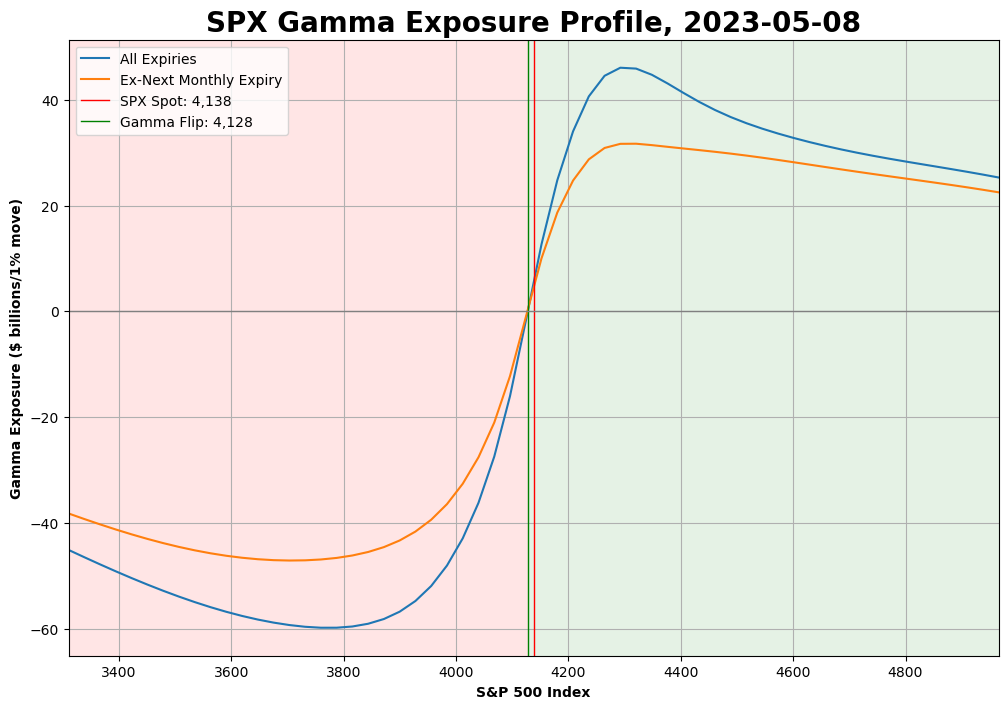

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import timedelta, date

def calcGammaEx(S, K, vol, T, OI, r=0, q=0):
    if T == 0 or vol == 0:
        return 0

    d1 = (np.log(S/K) + (r - q + 0.5 * vol**2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(-q * T) * norm.pdf(d1) / (S * vol * np.sqrt(T))
    gamma_exposure = OI * 100 * S * S * 0.01 * gamma 
    
    return gamma_exposure

def isThirdFriday(d):
    return d.weekday() == 4 and 15 <= d.day <= 21

filename = 'spx_quotedata.csv'
optionsFile = open(filename, 'rt', encoding='UTF8')
optionsFileData = optionsFile.readlines()
optionsFile.close()

spotLine = optionsFileData[1]
spotPrice = float(spotLine.split(',')[1].split(' ')[1])
fromStrike = 0.8 * spotPrice
toStrike = 1.2 * spotPrice

dateLine = optionsFileData[2]
todayDate = dateLine.split('Date: ')[1].split(',')
monthDay = todayDate[0].split(' ')

year = int(monthDay[0][:-1])
month = int(monthDay[1][:-1])
day = int(monthDay[2][:-1])
todayDate = date(year, month, day)

df = pd.read_csv(filename, sep=",", header=None, skiprows=4)
df.columns = ['ExpirationDate','Calls','CallLastSale','CallNet','CallBid','CallAsk','CallVol',
              'CallIV','CallDelta','CallGamma','CallOpenInt','StrikePrice','Puts','PutLastSale',
              'PutNet','PutBid','PutAsk','PutVol','PutIV','PutDelta','PutGamma','PutOpenInt']

df['ExpirationDate'] = pd.to_datetime(df['ExpirationDate'], format='%a %b %d %Y')
df['StrikePrice'] = df['StrikePrice'].astype(float)
df['CallIV'] = df['CallIV'].astype(float)
df['PutIV'] = df['PutIV'].astype(float)
df['CallGamma'] = df['CallGamma'].astype(float)
df['PutGamma'] = df['PutGamma'].astype(float)
df['CallOpenInt'] = df['CallOpenInt'].astype(float)
df['PutOpenInt'] = df['PutOpenInt'].astype(float)

df['daysTillExp'] = [np.busday_count(todayDate, x.date())/252 for x in df.ExpirationDate]
df['IsThirdFriday'] = [isThirdFriday(x) for x in df.ExpirationDate]

levels = np.linspace(fromStrike, toStrike, 60)

thirdFridays = df.loc[df['IsThirdFriday'] == True]
nextMonthlyExp = thirdFridays['ExpirationDate'].min()

totalGamma = []
totalGammaExFri = []

for level in levels:
    df['callGammaEx'] = df.apply(lambda row : calcGammaEx(level, 
                                                          row['StrikePrice'],
                                                          row['CallIV'], 
                                                          row['daysTillExp'], 
                                                          row['CallOpenInt']),
                                 axis=1)

    df['putGammaEx'] = df.apply(lambda row : calcGammaEx(level, 
                                                         row['StrikePrice'], 
                                                         row['PutIV'], 
                                                         row['daysTillExp'],
                                                         row['PutOpenInt']),
                                axis=1)    

    totalGamma.append(df['callGammaEx'].sum() - df['putGammaEx'].sum())

    exFri = df.loc[df['ExpirationDate'] != nextMonthlyExp]
    totalGammaExFri.append(exFri['callGammaEx'].sum() - exFri['putGammaEx'].sum())

totalGamma = np.array(totalGamma) / 1e9
totalGammaExFri = np.array(totalGammaExFri) / 1e9

zeroCrossIdx = np.where(np.diff(np.sign(totalGamma)))[0]

negGamma = totalGamma[zeroCrossIdx]
posGamma = totalGamma[zeroCrossIdx+1]
negStrike = levels[zeroCrossIdx]
posStrike = levels[zeroCrossIdx+1]

zeroGamma = (posStrike - ((posStrike - negStrike) * posGamma / (posGamma - negGamma)))[0]

fig, ax = plt.subplots(figsize=(12, 8))
plt.grid()
plt.plot(levels, totalGamma, label="All Expiries")
plt.plot(levels, totalGammaExFri, label="Ex-Next Monthly Expiry")
chartTitle = "SPX Gamma Exposure Profile, " + todayDate.strftime('%Y-%m-%d')
plt.title(chartTitle, fontweight="bold", fontsize=20)
plt.xlabel('S&P 500 Index', fontweight="bold")
plt.ylabel('Gamma Exposure ($ billions/1% move)', fontweight="bold")
plt.axvline(x=spotPrice, color='r', lw=1, label="SPX Spot: " + str("{:,.0f}".format(spotPrice)))
plt.axvline(x=zeroGamma, color='g', lw=1, label="Gamma Flip: " + str("{:,.0f}".format(zeroGamma)))
plt.axhline(y=0, color='grey', lw=1)
plt.xlim([fromStrike, toStrike])
trans = ax.get_xaxis_transform()
plt.fill_between([fromStrike, zeroGamma], min(totalGamma), max(totalGamma), facecolor='red', alpha=0.1, transform=trans)
plt.fill_between([zeroGamma, toStrike], min(totalGamma), max(totalGamma), facecolor='green', alpha=0.1, transform=trans)
plt.legend()
plt.show()